## To dos:

### ipmag functions to be made:

- [ ] ipmag.find_EI() clean up for ipmag inclusion including introductory function comments
- [ ] ipmag.dmag_magic() find way to filter by site


### [ ]update ipmag.sb_vgp_calc so that column fields can be specified (similar to what was done with vgp_calc)

### ipmag/pmag functions that already exist that should be demonstrated:

- [ ] ipmag.sb_vgp_calc
- [ ] ipmag.download_magic

In [1]:
# With the PmagPy folder in the PYTHONPATH, 
# the function modules from PmagPy can be imported
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.pmag as pmag

from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
# %config InlineBackend.figure_formats = {'svg',}

## Download Magic File

To retrieve data from the MagIC database, you will download a contribution file that will look something like this: *magic_contribution_10231.txt*.

A "contribution" is often made up of several MagIC files (one for each magnetic experiment) that have been concatenated into a single text file. The function **ipmag.download_magic** is able to recognize and separate these different experiments. It then writes individual text files for each (the file names are generated automatically by experiment). 

Let's unpack the MagIC contribution of Swanson-Hysell et al., 2014 (MagIC contribution 10231).

In [2]:
# ipmag.download_magic('magic_contribution_10231.txt', 
#                      dir_path='./Additional_Notebook_Output/download_magic',
#                      input_dir_path='./Example_Data/Swanson-Hysell2014',
#                     overwrite=True);

The outputted print statements of this function are quite thorough, so you should now know where everything is. For example, let's look for the main measurments folder that was just written, *magic_measurements*. Above we saw this output:
```
unpacking:  ./Additional_Notebook_Output/download_magic/magic_measurements.txt
13648  read in
13648  records written to file  ./Additional_Notebook_Output/download_magic/Location_1/magic_measurements.txt
13648  stored in  ./Additional_Notebook_Output/download_magic/Location_1/magic_measurements.txt
```

We can now read this file using the function **pmag.magic_read**.

find EI not working very well right now. seems to work if     
return Es,Is,Fs,V2s

at end of pmag.find_f rather than:
return [0],[0],[0],[0]

But I don't want to change for fear of breaking find_EI.py

Need to find out what exactly the exception is in find_f that returns zeros

**find_EI tends to work pretty well with distributions that have steep original inclinations (e.g. the example in the cookbook with an original inclination of 61)**

suspecting that intensity data could be important part of this analysis as it concerns the TK03 model (I am garnering this from Tauxe and Kent,2003) - will test with example dataset (which includes intensity data) both with variable intensity and as unit vectors

**definitely a problem with find_f**

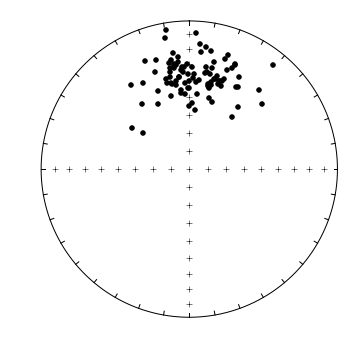

In [3]:
example_file = open('/Users/lukefairchild765/GitHub_files/PmagPy/data_files/find_EI/find_EI_example.dat')
example_read = example_file.readlines()
example_file.close()

example_data = []
for data in example_read:
    data = data.split()
    di = map(float,data)
    example_data.append(di)

plt.figure(figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(di_block=example_data)

In [4]:
data = np.loadtxt('/Users/lukefairchild765/GitHub_files/PmagPy/data_files/find_EI/find_EI_example.dat')

In [2]:
def doprinc(data):
    """
    gets principal components from data in form of an array of [dec,inc] data.
    """
    ppars={}
    rad=np.pi/180.
    X=pmag.dir2cart(data)
    #for rec in data:
    #    dir=[]
    #    for c in rec: dir.append(c)
    #    cart= (dir2cart(dir))
    #    X.append(cart)
#   put in T matrix
#
    T=np.array(pmag.Tmatrix(X))
#
#   get sorted evals/evects
#
    t,V=pmag.tauV(T)
    Pdir=pmag.cart2dir(V[0])
    ppars['Edir']=pmag.cart2dir(V[1]) # elongation direction
    dec,inc=pmag.doflip(Pdir[0],Pdir[1])
    ppars['dec']=dec
    ppars['inc']=inc
    ppars['N']=len(data)
    ppars['tau1']=t[0]
    ppars['tau2']=t[1]
    ppars['tau3']=t[2]
    Pdir=pmag.cart2dir(V[1])
    dec,inc=pmag.doflip(Pdir[0],Pdir[1])
    ppars['V2dec']=dec
    ppars['V2inc']=inc
    Pdir=pmag.cart2dir(V[2])
    dec,inc=pmag.doflip(Pdir[0],Pdir[1])
    ppars['V3dec']=dec
    ppars['V3inc']=inc
    return ppars

In [3]:
def find_f(data):
    rad=np.pi/180.
    Es,Is,Fs,V2s=[],[],[],[]
    ppars=doprinc(data)
    D=ppars['dec']
    Decs,Incs=data.transpose()[0],data.transpose()[1]
    Tan_Incs=np.tan(Incs*rad)
    for f in np.arange(1.,.2 ,-.01):
        U=np.arctan((1./f)*Tan_Incs)/rad
        fdata=np.array([Decs,U]).transpose()
        ppars=doprinc(fdata)
        Fs.append(f)
        # find elongation parameter as defined by Tauxe (1998)
        Es.append(ppars["tau2"]/ppars["tau3"])
        ang = pmag.angle([D,0],[ppars["V2dec"],0])
        if 180.-ang<ang:ang=180.-ang
        V2s.append(ang)
        Is.append(abs(ppars["inc"]))
        ###
        if pmag.EI(abs(ppars["inc"]))<=Es[-1]:
            ###
            del Es[-1]
            del Is[-1]
            del Fs[-1]
            del V2s[-1]
            if len(Fs)>0:
                for f in np.arange(Fs[-1],.2 ,-.005):
                    U=np.arctan((1./f)*Tan_Incs)/rad
                    fdata=np.array([Decs,U]).transpose()
                    ppars=doprinc(fdata)
                    Fs.append(f)
                    Es.append(ppars["tau2"]/ppars["tau3"])
                    Is.append(abs(ppars["inc"]))
                    ang=pmag.angle([D,0],[ppars["V2dec"],0])
                    if 180.-ang<ang:ang=180.-ang
                    V2s.append(ang)
                    if EI(abs(ppars["inc"]))<=Es[-1]:
                        return Es,Is,Fs,V2s
    return [0],[0],[0],[0]


In [4]:
def EI(inc):
    poly_tk03= [3.15976125e-06,  -3.52459817e-04,  -1.46641090e-02,   2.89538539e+00]
    return poly_tk03[0]*inc**3 + poly_tk03[1]*inc**2 + poly_tk03[2]*inc + poly_tk03[3]

In [5]:
from IPython.display import clear_output
import sys
def find_EI(data, nb=1000, save = False, save_folder = '.', fmt='svg'):
    """
    Applies series of assumed flattening factor and "unsquishes" inclinations assuming tangent function.
    Finds flattening factor that gives elongation/inclination pair consistent with TK03.  
    Finds bootstrap confidence bounds

    Arguments
    -----------
    data: a nested list of dec/inc pairs
 
    Keywords
    -----------
    nb: number of bootstrapped pseudo-samples (default is 1000)

    Output
    -----------
    four plots:   1) equal area plot of original directions
                  2) Elongation/inclination pairs as a function of f,  data plus 25 bootstrap samples
                  3) Cumulative distribution of bootstrapped optimal inclinations plus uncertainties.
                     Estimate from original data set plotted as solid line
                  4) Orientation of principle direction through unflattening
                      
    NOTE: If distribution does not have a solution, plot labeled: Pathological.  Some bootstrap samples may have
       valid solutions and those are plotted in the CDFs and E/I plot.
    """        
    print "Bootstrapping.... be patient"
    print ""
    sys.stdout.flush()
    
    upper,lower=int(round(.975*nb)),int(round(.025*nb))
    print upper, lower
    E,I=[],[]
    
    plt.figure(num=1,figsize=(4,4))
    ipmag.plot_net(1)
    ipmag.plot_di(di_block=data)
    
    ppars=pmag.doprinc(data)
    Io=ppars['inc']
    n=ppars["N"]
    Es,Is,Fs,V2s=pmag.find_f(data)
    Inc,Elong=Is[Es.index(min(Es))],Es[Es.index(min(Es))]
#     Inc,Elong=Is[-1],Es[-1]
    
    plt.figure(num=2,figsize=(4,4))
    plt.plot(Is,Es,'r')
    plt.xlabel("Inclination")
    plt.ylabel("Elongation")
    plt.text(Inc,Elong,' %3.1f'%(Fs[-1]))
    plt.text(Is[0]-2,Es[0],' %s'%('f=1'))
    
#     plt.figure(num=PLTS['ei'], figsize=(5,5))
#     plt.figure(num=PLTS['cdf'], figsize=(5,5))
#     plt.figure(num=PLTS['v2'], figsize=(5,5))
    

#     pmagplotlib.drawFIGS(PLTS)
            

#     pmagplotlib.plotEI(PLTS['ei'],Es,Is,Fs[-1])
#     pmagplotlib.plotV2s(PLTS['v2'],V2s,Is,Fs[-1])
    b=0
    
    while b < nb:
        bdata = pmag.pseudo(data)
        Es,Is,Fs,V2s = find_f(bdata)
        if b<25:
            plt.plot(Is,Es,'y')
#         if len(Es)>0:
        if Es[-1] != 0:
            ppars=pmag.doprinc(bdata)
            I.append(abs(Is[-1]))
            E.append(Es[-1])
            b += 1
#     print lower, upper
    I.sort()
    E.sort()
    print len(I)
    Eexp=[]
    for i in I:
        Eexp.append(EI(i))
    plt.plot(I,Eexp,'g-')
    if Inc==0:
        title= 'Pathological Distribution: '+'[%7.1f, %7.1f]' %(I[lower],I[upper])
    else:
        title= '%7.1f [%7.1f, %7.1f]' %(Inc, I[lower],I[upper])
   
    cdf_fig_num = 3
    plt.figure(num=cdf_fig_num,figsize=(4,4))
    pmagplotlib.plotCDF(cdf_fig_num,I,'Inclinations','r',title)
    pmagplotlib.plotVs(cdf_fig_num,[I[lower],I[upper]],'b','--')
    pmagplotlib.plotVs(cdf_fig_num,[Inc],'g','-')
    pmagplotlib.plotVs(cdf_fig_num,[Io],'k','-')
    
    # plot corrected directional data
    decs, incs = ipmag.unpack_di_block(data)
    unsquished_incs = ipmag.unsquish(incs, Fs[-1])
    plt.figure(num=4,figsize=(4,4))
    ipmag.plot_net(4)
    ipmag.plot_di(decs,unsquished_incs)

    print "The original inclination was: " + str(Io)
    print ""
    print "The corrected inclination is: " + str(Inc)
    print "with bootstrapped confidence bounds of: " +  str(I[lower]) + ' to ' + str(I[upper])
    print "and elongation parameter of: " + str(Elong)
    return ipmag.make_di_block(decs, unsquished_incs)

In [6]:
pmag.EI(0)

2.89538539

Dec: 359.3  Inc: 30.3
Number of directions in mean (n): 100
Angular radius of 95% confidence (a_95): 1.8
Precision parameter (k) estimate: 59.5


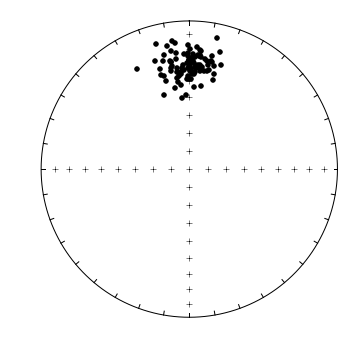

In [7]:
fisher_directions = ipmag.fishrot(k=60, n=100, dec=0, inc=30)
fisher_directions_mean = ipmag.fisher_mean(di_block=fisher_directions)
ipmag.print_direction_mean(fisher_directions_mean)
plt.figure(figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(di_block=fisher_directions)

In [8]:
ppars = doprinc(fisher_directions)
ppars['tau2']/ppars['tau3']

1.139089533688689

In [9]:
directions = pd.DataFrame(fisher_directions,columns=['dec','inc','length'])
directions.head()

,dec,inc,length
0,3.381299,44.059993,1
1,5.945736,30.312459,1
2,2.418093,34.692161,1
3,6.157083,31.256407,1
4,359.279605,32.037309,1


In [10]:
declinations = directions.dec.tolist()
inclinations = directions.inc.tolist()

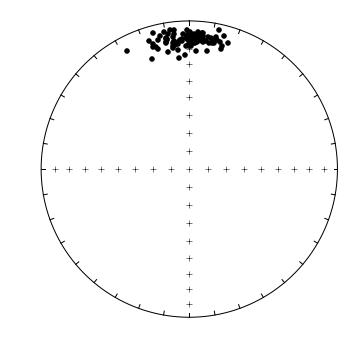

In [11]:
# squish all inclinations
squished_incs = []
for inclination in inclinations:
    squished_incs.append(ipmag.squish(inclination, 0.4))

# plot the squished directional data
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(declinations,squished_incs)
squished_DIs = np.array(zip(declinations,squished_incs))

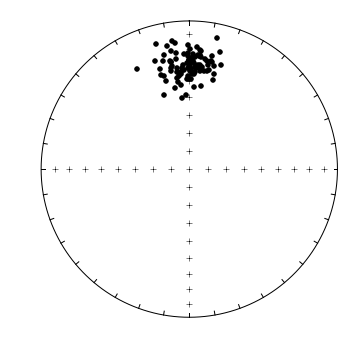

In [12]:
unsquished_incs = []
for squished_inc in squished_incs:
    unsquished_incs.append(ipmag.unsquish(squished_inc, 0.4))

# plot the squished directional data
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(declinations,unsquished_incs)

Bootstrapping.... be patient

975 25
1000
The original inclination was: 13.3665375061

The corrected inclination is: 30.880870557
with bootstrapped confidence bounds of: 35.0722080982 to 47.7613545157
and elongation parameter of: 1.13868520033


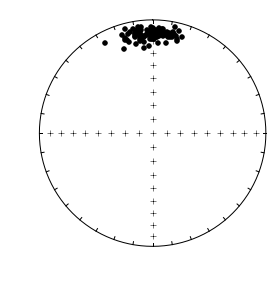

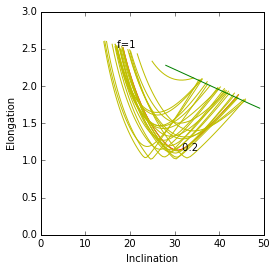

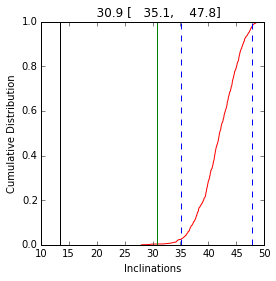

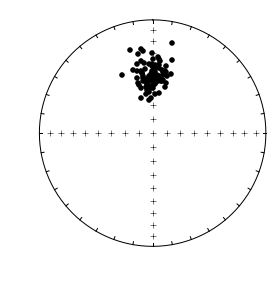

In [13]:
findEI_corr_dirs = find_EI(data=squished_DIs,nb=1000)

In [17]:
ppars = doprinc(findEI_corr_dirs)
ppars['tau2']/ppars['tau3']

1.8023037959014985

In [18]:
# corr_dec, corr_inc = ipmag.unpack_di_block(findEI_corr_dirs)
# ipmag.fishqq(corr_dec, corr_inc)

In [19]:
VGPs = ipmag.tk03(n=1000,lat=15) #set at 100,000 this takes a long time to run
VGP_dataframe = pd.DataFrame(VGPs,columns=['dec_tc','inc_tc','int'])
VGP_dataframe['site_lat'] = pd.Series(np.random.uniform(plat,plat,size=len(VGPs)))
VGP_dataframe['site_lon'] = pd.Series(np.random.uniform(0,0,size=len(VGPs)))

ipmag.vgp_calc(VGP_dataframe)    

greater_10 = []
greater_20 = []
greater_30 = []
greater_40 = []
greater_50 = []
angles = []
for n in range(len(VGP_dataframe)):
    true_north = (0,90)
    vgp = (VGP_dataframe['vgp_lon'][n],VGP_dataframe['vgp_lat'][n])
    angle = pmag.angle(true_north,vgp)
    angles.append(angle[0])
    if angle > 10:
        greater_10.append(angle[0])
    if angle > 20:
        greater_20.append(angle[0])
    if angle > 30:
        greater_30.append(angle[0])
    if angle > 40:
        greater_40.append(angle[0])
    if angle > 50:
        greater_50.append(angle[0])
    
n, bins, patches = plt.hist(angles, bins=50)
plt.vlines(50.6,0,5000,linestyles='dotted')
plt.xlim(0,90)
plt.ylim(0,n.max())
plt.xlabel('angle between TK03.GAD VGP and geographic north')
plt.ylabel('n')
plt.show()

NameError: name 'plat' is not defined

In [20]:
ipmag.inc_from_lat(20)

36.052388732387911

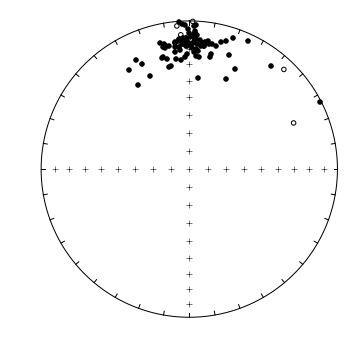

In [21]:
tk03 = ipmag.tk03(n=100, lat=20)
tk03_incs = []
tk03_decs, tk03_incs = ipmag.unpack_di_block(tk03)
tk03_squished_incs = ipmag.squish(tk03_incs, 0.4)
# tk03_dir = []
# # for cart in tk03:
# #     tk03_dir.append(pmag.cart2dir(cart))
tk_diblock_squished = ipmag.make_di_block(tk03_decs, tk03_squished_incs)
plt.figure(figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(di_block=tk_diblock_squished)

Bootstrapping.... be patient

975 25
1000
The original inclination was: 16.2875180937

The corrected inclination is: 29.857571181
with bootstrapped confidence bounds of: 23.1857149685 to 40.6496298209
and elongation parameter of: 2.23081275615


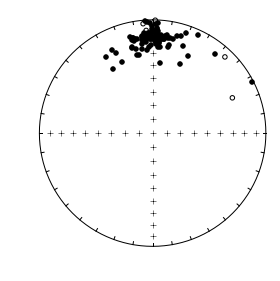

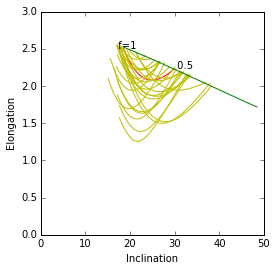

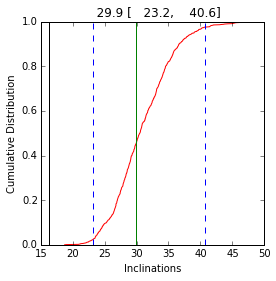

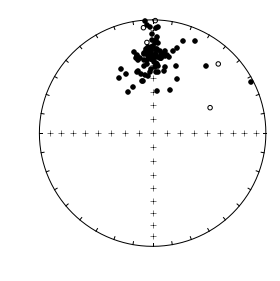

In [24]:
tk03_findEI_test = find_EI(np.array(tk_diblock_squished))

In [25]:
ipmag.fisher_mean(di_block=tk03)

{'alpha95': nan,
 'csd': nan,
 'dec': 0.42935926179787187,
 'inc': 36.361163490950247,
 'k': -4.8791759670891928e-05,
 'n': 100,
 'r': 2029131.1451722695}

Seems like the problem is that we are generating fisher-distributed directions and, after squishing them, expecting the tk03.GAD-based find_EI to unsquish them back into their fisher distribution. But TK03.GAD assumes some elongation of the directional data (not necessarily consistent with a fisher-distribution, which ideally minimizes elongation). In the case above, we see that unsquishing our squished data with **ipmag.unsquish** returns the data to the original fisher distribution (what we want) with an elongation parameter very close to 1. When "unsquishing" using find_EI, find_EI finds a TK03.GAD-consistent distribution before it fully unsquishes our directions - it returns a lesser (un)flattening factor of 0.3 and a distribution with an elongation parameter of approximately 1.7. The reason why find_EI tends to work better with steeper directions is that, according to the TK03.GAD model, directions at higher latitudes tend to be more consistent with a Fisherian distribution. 

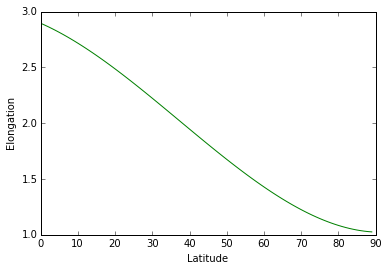

In [7]:
Eexp = []
I = []
for i in np.arange(90):
    I.append(i)
    Eexp.append(EI(i))
plt.plot(I,Eexp,'g-')
plt.ylabel('Elongation')
plt.xlabel('Latitude')
plt.show()

In [ ]:
find_EI(np.array(fisher_directions))

## Rework example from Tauxe and Kent (2003)

Dec: 359.6  Inc: 46.5
Number of directions in mean (n): 1000
Angular radius of 95% confidence (a_95): 1.1
Precision parameter (k) estimate: 17.9


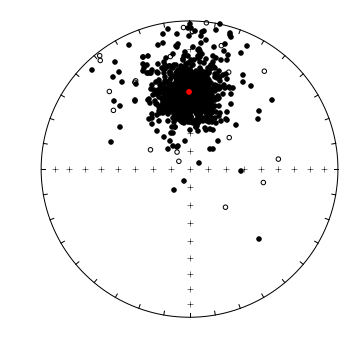

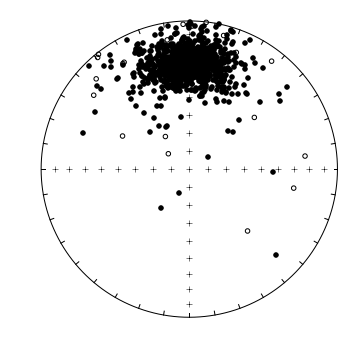

In [26]:
tk03 = ipmag.tk03(n=1000, lat=30)
tk03_incs = []
tk03_decs, tk03_incs = ipmag.unpack_di_block(tk03)
tk03_diblock = ipmag.make_di_block(tk03_decs, tk03_incs)
tk03_mean = ipmag.fisher_mean(di_block = tk03_diblock)
plt.figure(figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(di_block=tk03_diblock, label='Original at 30 deg&;')
ipmag.plot_di_mean(tk03_mean['dec'], tk03_mean['inc'], tk03_mean['alpha95'], color='r')
ipmag.print_direction_mean(tk03_mean)
plt.show()

tk03_squished_incs = ipmag.squish(tk03_incs, 0.5)
# tk03_dir = []
# # for cart in tk03:
# #     tk03_dir.append(pmag.cart2dir(cart))
tk_diblock_squished = ipmag.make_di_block(tk03_decs, tk03_squished_incs)

plt.figure(figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(di_block=tk_diblock_squished, label='Squished')
plt.show()

Bootstrapping.... be patient

975 25
1000
The original inclination was: 29.2248105005

The corrected inclination is: 47.5524653767
with bootstrapped confidence bounds of: 44.2077297955 to 50.6384374057
and elongation parameter of: 1.75796505766


[[329.97129276619967, 40.067914864281285, 1.0],
 [5.1384253506695083, 47.896700421997615, 1.0],
 [4.8090116072033497, 18.243900850877466, 1.0],
 [353.74565095010763, 52.16654039461546, 1.0],
 [14.105050303785141, 27.015843016146313, 1.0],
 [351.69450626284964, 49.69849500114745, 1.0],
 [0.50295106228124231, 38.548824097763806, 1.0],
 [5.9347361930435678, 32.684798607966634, 1.0],
 [352.92417808008958, 43.62117558960972, 1.0],
 [359.79752094893877, 49.733800884673649, 1.0],
 [355.04918048124489, 40.574217788205353, 1.0],
 [340.92628813665436, 32.595379565221734, 1.0],
 [356.51630389609926, 35.858574077870024, 1.0],
 [21.465485749119839, 47.749309503436102, 1.0],
 [16.364592695586026, 44.532375077790178, 1.0],
 [359.09820926332867, 49.98597853994815, 1.0],
 [4.3031205872909091, 43.363737906016404, 1.0],
 [355.39571866964354, 43.822839760207806, 1.0],
 [349.59968114241889, 54.535522369004376, 1.0],
 [328.62676228582342, -27.280649006306806, 1.0],
 [0.48580771951987672, 42.273673952813674,

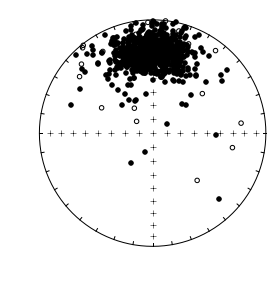

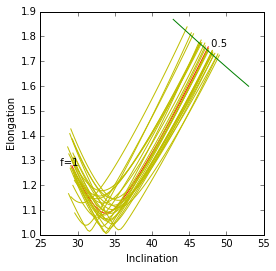

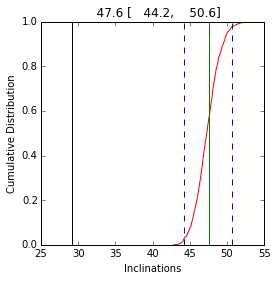

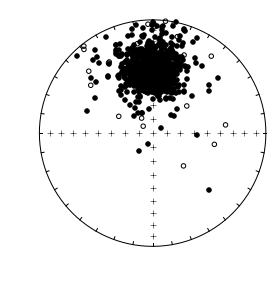

In [27]:
find_EI(np.array(tk_diblock_squished))